In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
datetime.now()

datetime.datetime(2020, 8, 29, 16, 8, 48, 999120)

In [3]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [4]:
url = 'https://ncov.dxy.cn/ncovh5/view/pneumonia'
driver.get(url)

### Extract date

In [5]:
content = driver.page_source
soup =BeautifulSoup(content, 'lxml')


In [6]:
data = soup.findAll(text=re.compile("截至.+"))
data

['try { window.getTimelineService1 = [{"id":80307,"pubDate":1598702266000,"pubDateStr":"4小时前","title":"世卫组织：全球新冠肺炎确诊病例超过2453万例","summary":"根据世卫组织最新实时统计数据，截至欧洲中部夏令时间8月29日10时41分（北京时间8月29日16时41分），全球累计新冠肺炎确诊病例24537560例，累计死亡病例832879例。","infoSource":"央视新闻app","sourceUrl":"http://app.cctv.com/special/cportal/detail/arti/index.html?id=ArtiYiuioD2pKPHt0BrKuRER200829&isfromapp=1","provinceId":""},{"id":80269,"pubDate":1598692914000,"pubDateStr":"6小时前","title":"疫情导致肯尼亚航空上半年亏损高达1.32亿美元","summary":"The East African28日消息，由于疫情导致的航班停飞，肯尼亚航空公司（KQ）在截至2020年6月的半年里净亏损扩大了67.3%，达到了143.3亿先令 (1.32亿美元)。该公司周五表示，与去年同期的240万乘客数量相比，今年上半年的乘客数量仅为110万，大幅影响了公司收入。","infoSource":"央视新闻app","sourceUrl":"http://app.cctv.com/special/cportal/detail/arti/index.html?id=ArtihnPpaXA9w9MONzJv8LcV200829&isfromapp=1","provinceId":""},{"id":80247,"pubDate":1598684186000,"pubDateStr":"9小时前","title":"乌鲁木齐市多地区疫情风险等级下调 生产生活秩序正有序恢复","summary":"经新疆新冠肺炎疫情防控工作指挥部研究决定：自8月29日0时起，乌鲁木齐市天山区、沙依巴克区疫情风险等级由高风险调整为低风险；乌鲁木齐经济技术开发区（头屯河区）、高新技术产业开发区（新市区）、水磨

In [7]:
for s in data:
    m = re.search("截至.*(202\d-\d+-\d+ \d+:\d+)", s)
    if m is not None:
        data_date_time = m.group(1)
data_date_time

'2020-08-29 23:55'

### Extract data (summary)

In [8]:
data = soup.findAll(text=re.compile('\"summary.+\"confirmedCount\":\d'))

data


['try { window.getStatisticsService = {"id":1,"createTime":1579537899000,"modifyTime":1598716506000,"infectSource":"该字段已替换为说明2","passWay":"该字段已替换为说明3","imgUrl":"https://img1.dxycdn.com/2020/0201/450/3394153392393266839-135.png","dailyPic":"https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png,https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png,https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png,https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png,https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png,https://img1.dxycdn.com/2020/0211/089/3395998939840182072-135.png","dailyPics":["https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png","https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png","https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png","https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png","https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png","https://i

In [9]:
m = re.search('\"confirmedCount\":(\d+)', data[0])
summary_confirmed_count = int(m.group(1))


m = re.search('\"curedCount\":(\d+)', data[0])
summary_cured_count = int(m.group(1))

m = re.search('\"deadCount\":(\d+)', data[0])
summary_dead_count = int(m.group(1))


In [10]:
# make a dataframe
df = pd.DataFrame({
    'datetime': data_date_time,
    'confirmed': summary_confirmed_count,
    'cured': summary_cured_count,
    'dead': summary_dead_count
}, index=[0])
df

,datetime,confirmed,cured,dead
0,2020-08-29 23:55,90342,84919,4725


### Save to file

In [11]:
from pathlib import Path
csv_file = '../data/china-summary-cases.csv'

if Path(csv_file).exists():
    # read out the old data - then merge with new data and remove duplicates based on datetime
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)

In [12]:
df.sort_values(by=['datetime'], inplace=True)

df.to_csv(csv_file, index=False)


### Plot graph

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = '../images/china-summary-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

df.set_index('datetime_idx', inplace=True)
df.drop(['datetime'], axis=1, inplace=True)


In [14]:
df

,confirmed,cured,dead
datetime_idx,,,
2020-02-02 10:22:00,14483,379,304
2020-02-02 10:28:00,14483,380,304
2020-02-02 11:19:00,14489,385,304
2020-02-02 11:54:00,14489,397,304
2020-02-02 15:01:00,14490,430,304
...,...,...,...
2020-08-29 15:10:00,90323,84883,4725
2020-08-29 18:13:00,90341,84919,4725
2020-08-29 18:25:00,90342,84919,4725


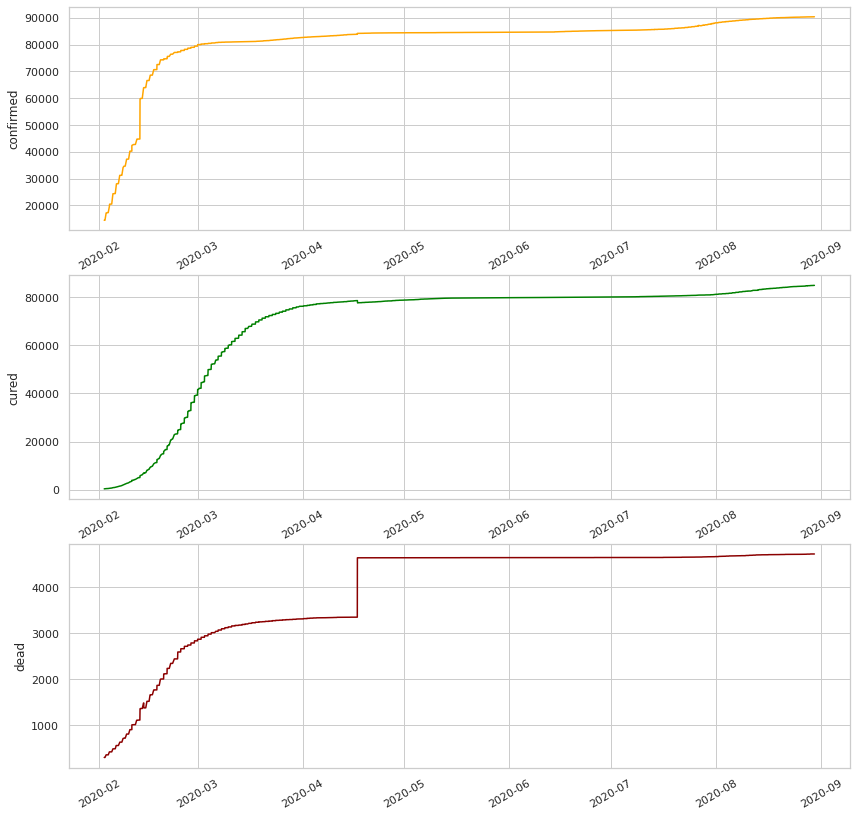

In [15]:
if df.shape[0]>1:
    # line chart when having at least a few points
    sns.set(rc={'figure.figsize':(14,14)})
    sns.set(style="whitegrid")

    fig, axs = plt.subplots(nrows=3)

    sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
    sns.lineplot(x=df.index, y = 'cured', data=df, ax= axs[1], estimator=None, color='green')
    sns.lineplot(x=df.index, y = 'dead', data=df, ax= axs[2], estimator=None, color='darkred')

    for ax in axs:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
else:

    ax = df.plot(kind='bar', stacked=True, figsize=(9,6))
    fig = ax.get_figure()
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(0) 


In [16]:
fig.savefig(png_file)